# Driver for VAE
- We will use a Variational Autoencoder to generate more malignant data

In [28]:
import numpy as np
import pandas as pd
import os
import h5py
import cv2
import matplotlib.pyplot as plt
import tqdm
#TODO: change this to your own directory
current_dir = "/Users/thatblue340/Documents/Documents/GitHub/EECS-545-final-project"

In [58]:
from vae import CVAE
from torch import nn

## Data Loading
- Load images to train VAE

In [17]:
train_metadata = pd.read_csv(os.path.join(current_dir,'train-metadata.csv'),low_memory=False)
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [18]:
test_metadata = pd.read_csv(os.path.join(current_dir,'test-metadata.csv'),low_memory=False)
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [19]:
training_validation_hdf5 = h5py.File(f"{current_dir}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{current_dir}/test-image.hdf5", 'r')

## Preprocess data
- Only take the malignant images
- Resize them to (128, 128, 3)
- Normalize pixel values to [0,1]

In [47]:
# import training images 
train_images = []
for i in tqdm.tqdm(range(len(train_metadata))):
    if train_metadata.iloc[i]['target'] == 0: # skip non-target images
        continue
    image_id = train_metadata.iloc[i]['isic_id']
    image = training_validation_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    train_images.append(image)
train_images = np.array(train_images)


print(f"Training images shape: {train_images.shape}")

100%|██████████| 401059/401059 [00:09<00:00, 44083.07it/s]

Training images shape: (393, 128, 128, 3)


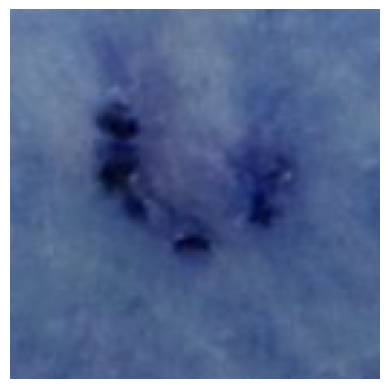

In [50]:
plt.imshow(train_images[0])
plt.axis('off') 
plt.show()

# Training with the VAE

## Create PyTorch Dataset
- contains the train_images
- uses this to train the VAE

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageArrayDataset(Dataset):
    def __init__(self, image_array):
        # image_array is expected to be (N, H, W, C)
        self.images = torch.tensor(image_array, dtype=torch.float32).permute(0, 3, 1, 2)  # to (N, C, H, W)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx]

# Create dataset and dataloader
train_dataset = ImageArrayDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Initialize VAE and Training Setup

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [55]:
model = CVAE(latent_dim=64).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [59]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [60]:
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_dataset):.4f}")

Epoch 1/50, Loss: 38232.1852
Epoch 2/50, Loss: 33829.6742
Epoch 3/50, Loss: 33371.1278
Epoch 4/50, Loss: 32977.0894
Epoch 5/50, Loss: 32928.7483
Epoch 6/50, Loss: 32846.2235
Epoch 7/50, Loss: 32752.5984
Epoch 8/50, Loss: 32686.0227
Epoch 9/50, Loss: 32570.3901
Epoch 10/50, Loss: 32397.1382
Epoch 11/50, Loss: 32012.4396
Epoch 12/50, Loss: 31800.6218
Epoch 13/50, Loss: 31668.7326
Epoch 14/50, Loss: 31629.9998
Epoch 15/50, Loss: 31565.7420
Epoch 16/50, Loss: 31583.0549
Epoch 17/50, Loss: 31681.1955
Epoch 18/50, Loss: 31582.3079
Epoch 19/50, Loss: 31507.1087
Epoch 20/50, Loss: 31491.3731
Epoch 21/50, Loss: 31472.3624
Epoch 22/50, Loss: 31449.3729
Epoch 23/50, Loss: 31447.8488
Epoch 24/50, Loss: 31445.3369
Epoch 25/50, Loss: 31443.9893
Epoch 26/50, Loss: 31450.2605
Epoch 27/50, Loss: 31436.6313
Epoch 28/50, Loss: 31420.6439
Epoch 29/50, Loss: 31411.5833
Epoch 30/50, Loss: 31399.7444
Epoch 31/50, Loss: 31397.4869
Epoch 32/50, Loss: 31411.1916
Epoch 33/50, Loss: 31388.4292
Epoch 34/50, Loss: 

In [61]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, model.latent_dim).to(device)
    generated = model.decode(z)
    generated = generated.cpu().numpy().transpose(0, 2, 3, 1)  # (B, C, H, W) -> (B, H, W, C)

Generated shape: torch.Size([10, 3, 128, 128])


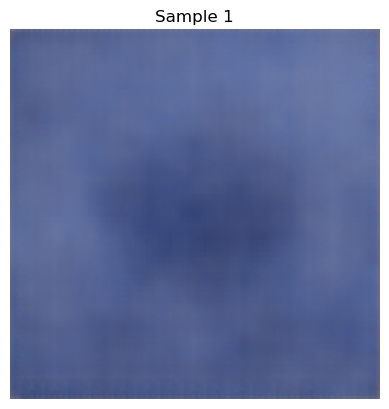

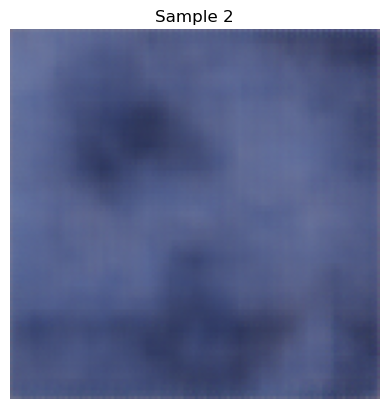

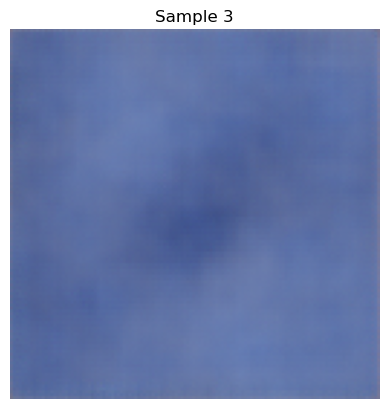

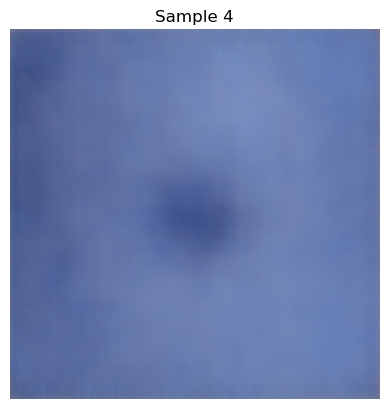

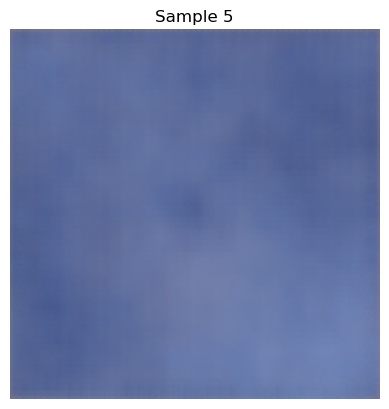

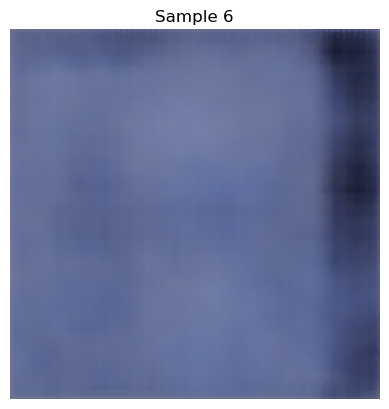

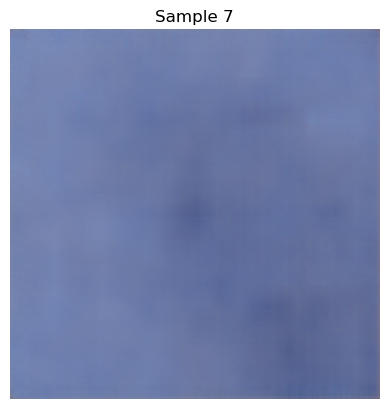

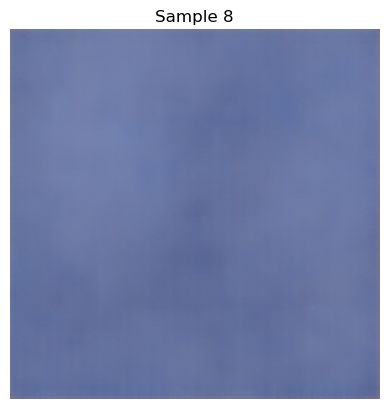

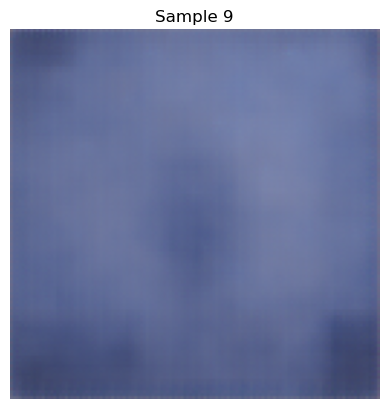

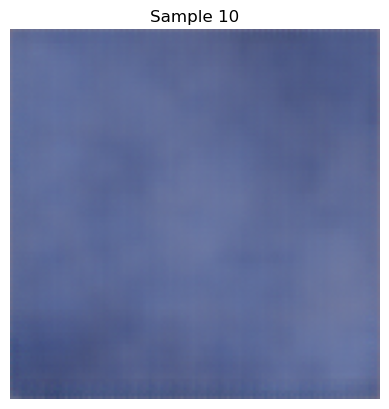

In [65]:
import matplotlib.pyplot as plt
import torch

# Generate 10 synthetic images
model.eval()
with torch.no_grad():
    z = torch.randn(10, model.latent_dim).to(device)  # sample from standard normal
    generated = model.decode(z).cpu()  # shape: (10, 3, 128, 128)
    print(f"Generated shape: {generated.shape}")

# Convert to (10, 128, 128, 3) for plotting
generated = generated.permute(0, 2, 3, 1).numpy()

for i in range(10):
    plt.imshow(generated[i])
    plt.axis('off')
    plt.title(f"Sample {i+1}")
    plt.show()
